In [1]:
import pylab
import fnmatch
import os
import random
import cv2

import numpy as np
import skimage.io as io
import scipy.io as sio
import matplotlib.pyplot as plt
import ipywidgets as wg
import scipy.interpolate as interp

from matplotlib.image import imread
from tqdm.notebook import tqdm
from ipywidgets import interactive
from scipy import ndimage
from scipy.spatial import distance
from scipy.stats import gaussian_kde

## Helpers

In [2]:
IMAGE_PATH = '../images/train/'
FIXATION_PATH = '../fixations/train/'
MAP_PATH = '../maps/train/'
GT_SLICE_PATH = '../3-sliced_maps/'
FIX_SLICE_PATH = '../3-sliced_fixations/'

SLICE_500_PATH = '../../multiduration-saliency-master/data/heatmaps_accum/500/'
SLICE_3000_PATH = '../../multiduration-saliency-master/data/heatmaps_accum/3000/'
SLICE_5000_PATH = '../../multiduration-saliency-master/data/heatmaps_accum/5000/'

TRAINING_SIZE = 10000
MDSEM_SIZE = 500

W = 640
H = 480

In [3]:
def create_fixation_map(fix):
    fix_map = np.zeros(shape=(W,H))
    for coord in fix:
        fix_map[coord[0] - 1, coord[1] - 1] += 1
        
    return fix_map.T

In [4]:
def create_image(fix, filter_size=19):
    return ndimage.filters.gaussian_filter(create_fixation_map(fix), filter_size)

In [5]:
def create_weighted_image(fix, filter_size=19):
    fix_map = np.zeros(shape=(W,H))
    for w, coord in fix:
        fix_map[coord[0] - 1, coord[1] - 1] += w
        
    return ndimage.filters.gaussian_filter(fix_map.T, filter_size)

In [6]:
def get_filenames(path):
    return [file for file in sorted(os.listdir(path)) if fnmatch.fnmatch(file, 'COCO_*.*')]

In [7]:
MAX_PIXEL_DISTANCE = np.linalg.norm([W, H])
ESTIMATED_TIMESTAMP_WEIGHT = 0.006

def get_saliency_volumes(filenames=get_filenames(FIXATION_PATH), etw=ESTIMATED_TIMESTAMP_WEIGHT, 
                         progress_bar=True):
    saliency_volumes = []
    errors = []
    
    filenames = tqdm(filenames) if progress_bar else filenames

    for filename in filenames:
        # 1. Extracting data from .mat files
        mat = sio.loadmat(FIXATION_PATH + filename)
        gaze = mat["gaze"]

        locations = []
        timestamps = []
        fixations = []

        for i in range(len(gaze)):
            locations.append(mat["gaze"][i][0][0])
            timestamps.append(mat["gaze"][i][0][1])
            fixations.append(mat["gaze"][i][0][2])

        # 2. Matching fixations with timestamps
        saliency_volume = []
        for i, observer in enumerate(fixations):
            fix_timestamps = []
            fix_time = 5000 / (len(observer) + 1)
            est_timestamp = 0

            for fixation in observer:
                distances = distance.cdist([fixation], locations[i], 'euclidean')[0][..., np.newaxis]
                time_diffs = abs(timestamps[i] - est_timestamp)
                min_idx = np.argmin(etw * time_diffs + distances)

                fix_timestamps.append([min(timestamps[i][min_idx][0], 5000), fixation.tolist()])
                errors.append(distances[min_idx])
                est_timestamp += fix_time

            if (len(observer) > 0):
                saliency_volume.append(fix_timestamps)

        saliency_volumes.append(saliency_volume)

    return saliency_volumes, np.mean(errors) / MAX_PIXEL_DISTANCE

In [8]:
def split_fixations(fix_timestamps, splitters):
    split_at = fix_timestamps[:,0].searchsorted(splitters)
    return np.split(fix_timestamps[:,1], split_at)

In [9]:
def format_image(heatmap, image, max_value):
    extended_map = heatmap[:,:,np.newaxis] / max_value
    adapted_map = extended_map * np.array([0.38, 1, 0.87]) #([1, 0.37, 0])
    
    return np.clip(adapted_map, 0, 1), np.clip(adapted_map + 0.5 * (1 - extended_map) * image / 255, 0, 1)

In [10]:
def display_images(maps, image, normalized=False):
    f, axarr = plt.subplots(2, len(maps), figsize=(24, 8))
    max_value = np.max(maps);

    for i in range(len(maps)):
        heatmap, image_heatmap = format_image(maps[i], image, np.max(maps[i]) if normalized else max_value)
        axarr[0,i].imshow(heatmap)
        axarr[1,i].imshow(image_heatmap)

In [11]:
def display_interactive(maps, image, normalized=False):
    max_value = np.max(maps);
    
    def f(i):
        f, axarr = plt.subplots(1, 2, figsize=(20, 6))
        heatmap, image_heatmap = format_image(maps[i], image, np.max(maps[i]) if normalized else max_value)
        axarr[0].imshow(heatmap)
        axarr[1].imshow(image_heatmap)
        plt.show()

    image_slider = interactive(f, i=wg.IntSlider(min=0, max=len(maps) - 1, step=1))
    output = image_slider.children[-1]
    return image_slider

# 3-Sliced ground truth

In [12]:
index = random.randint(0, MDSEM_SIZE - 1)

gt_filename = get_filenames(SLICE_500_PATH)[index]
ground_truths = [cv2.resize(imread(SLICE_500_PATH + gt_filename), dsize=(W,H), interpolation=cv2.INTER_CUBIC),
                cv2.resize(imread(SLICE_3000_PATH + gt_filename), dsize=(W,H), interpolation=cv2.INTER_CUBIC),
                cv2.resize(imread(SLICE_5000_PATH + gt_filename), dsize=(W,H), interpolation=cv2.INTER_CUBIC)]

saliency_volume = get_saliency_volumes([gt_filename[:-3] + 'mat'], progress_bar=False)[0][0]
image = imread(IMAGE_PATH + gt_filename[:-3] + 'jpg')

fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                  for fixation in fix_timestamps], key=lambda x: (x[0])))
maps = [create_image(bucket) for bucket in 
        split_fixations(fix_timestamps, [1000, 2500, 3500, 4000])[0::2]]

print('Cumulated number of fixations:', fix_timestamps.shape[0])

Cumulated number of fixations: 509


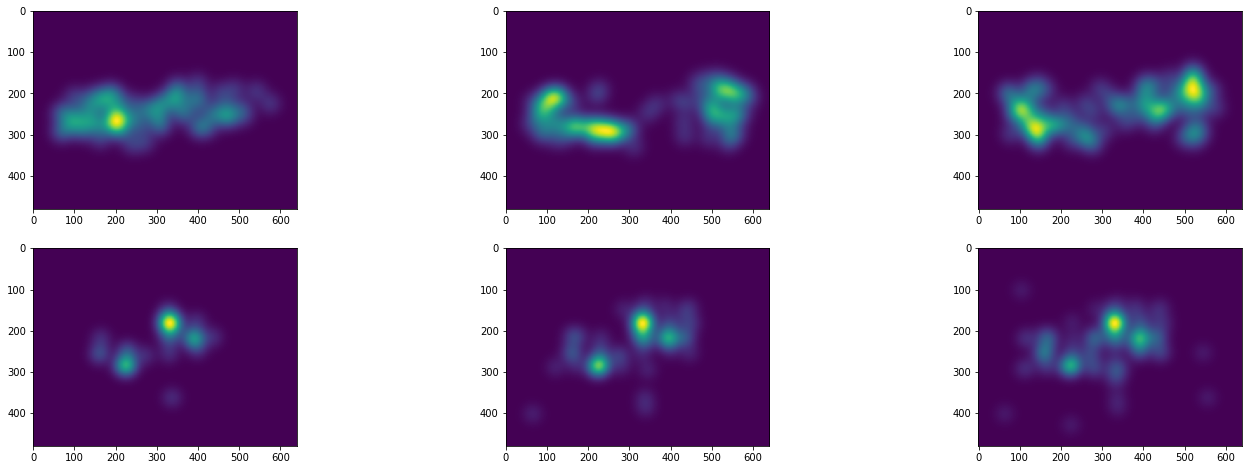

In [13]:
f, axarr = plt.subplots(2, 3, figsize=(24, 8))

for i in range(3):
    axarr[0,i].imshow(maps[i])
    
for i in range(3):
    axarr[1,i].imshow(ground_truths[i])

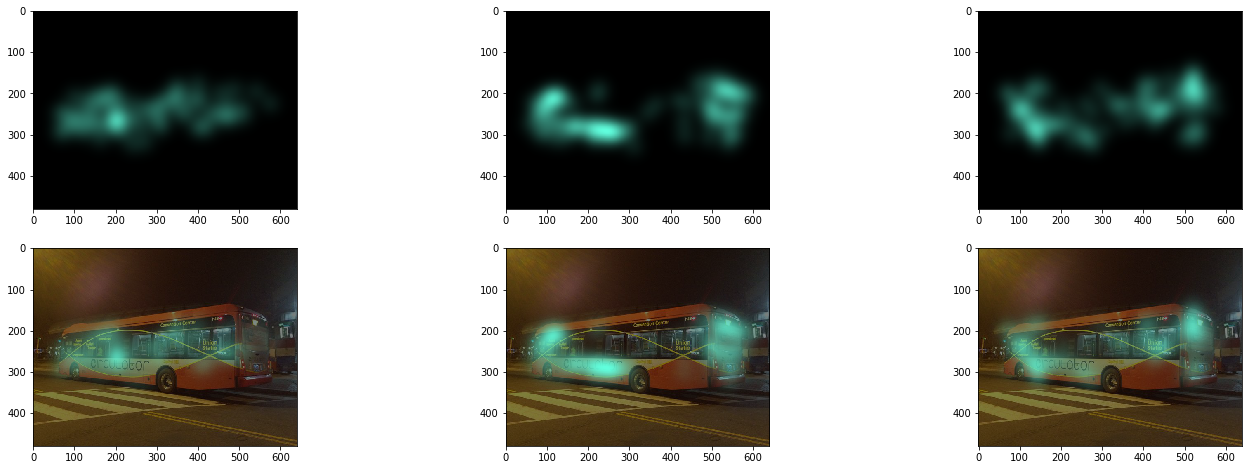

In [14]:
display_images(maps, image)

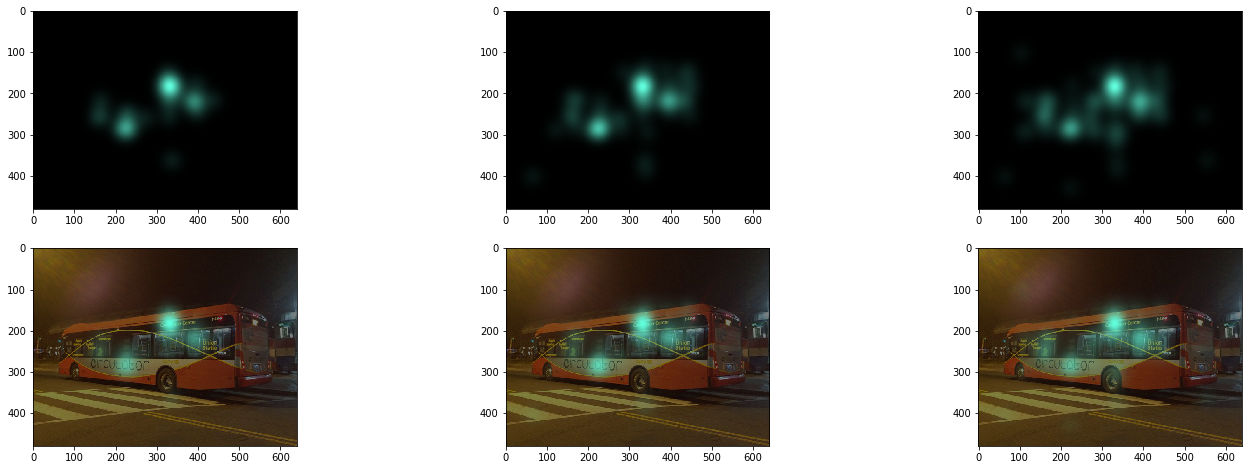

In [15]:
display_images(ground_truths, image)

### Generating ground truths heatmaps

In [16]:
filenames = get_filenames(FIXATION_PATH)
saliency_volumes, _ = get_saliency_volumes(filenames)

for i, saliency_volume in enumerate(tqdm(saliency_volumes)):
    fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                      for fixation in fix_timestamps], key=lambda x: (x[0])))
    maps = [create_image(bucket) for bucket in
            split_fixations(fix_timestamps, [1000, 2500, 3500, 4000])[0::2]]
    
    filename = filenames[i][:-3] + 'png'
    cv2.imwrite(GT_SLICE_PATH + '500/' + filename, 255 * maps[0] / maps[0].max())
    cv2.imwrite(GT_SLICE_PATH + '3000/' + filename, 255 * maps[1] / maps[1].max())
    cv2.imwrite(GT_SLICE_PATH + '5000/' + filename, 255 * maps[2] / maps[2].max())

KeyboardInterrupt: 

### Generating ground truths fixations

In [18]:
filenames = get_filenames(FIXATION_PATH)[5000:]
saliency_volumes, _ = get_saliency_volumes(filenames)

for i, saliency_volume in enumerate(tqdm(saliency_volumes)):
    fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                      for fixation in fix_timestamps], key=lambda x: (x[0])))
    fixation_maps = [create_fixation_map(bucket) for bucket in 
                     split_fixations(fix_timestamps, [1000, 2500, 3500, 4000])[0::2]]
    
    filename = filenames[i][:-3] + 'png'
    cv2.imwrite(FIX_SLICE_PATH + '500/' + filename, 255 * fixation_maps[0] / fixation_maps[0].max())
    cv2.imwrite(FIX_SLICE_PATH + '3000/' + filename, 255 * fixation_maps[1] / fixation_maps[1].max())
    cv2.imwrite(FIX_SLICE_PATH + '5000/' + filename, 255 * fixation_maps[2] / fixation_maps[2].max())

# Saliency volumes

### Finding the right weights for timestamp matching

In [17]:
def get_mean_down_edge(saliency_volumes):

    down_edge = []

    for saliency_volume in saliency_volumes:
        fix_lengths = [len(f) for f in saliency_volume]
        max_length = np.max(fix_lengths)
        interpolated_timestamps = []

        for fix_timestamps in saliency_volume:
            if len(fix_timestamps) > 1:
                timestamps = [timestamp for timestamp, coord in fix_timestamps]
                interpolated_timestamps.append(interp.interp1d(np.arange(len(timestamps)),timestamps)
                                               (np.linspace(0,len(timestamps)-1,max_length)))

        down_edge.append(
            np.minimum(np.array([np.convolve([1, -1], it, 'valid') for it in interpolated_timestamps]), 0).mean())

    return -np.mean(down_edge) / 5000

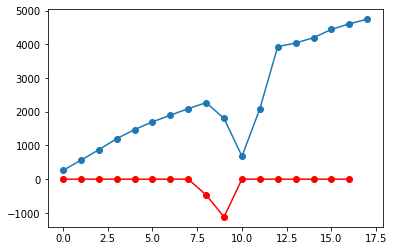

In [18]:
# Exemple for illustrating mean_down_edge

index = -11
saliency_volume = get_saliency_volumes(get_filenames(FIXATION_PATH)[0:1], progress_bar=False)[0][0]

fix_lengths = [len(f) for f in saliency_volume]
max_length = np.max(fix_lengths)
timestamps = [timestamp for timestamp, coord in saliency_volume[index]]
interpolated = interp.interp1d(np.arange(len(timestamps)),timestamps) \
                    (np.linspace(0,len(timestamps)-1,max_length))

plt.plot(np.array(interpolated), 'o-')
plt.plot(np.minimum(np.convolve([1, -1], interpolated, 'valid'), 0), 'ro-')

In [36]:
WEIGHT_SAMPLES = 500

filenames = np.random.choice(get_filenames(FIXATION_PATH), WEIGHT_SAMPLES, replace=False)
etws = np.logspace(-4, 0, 10)
me_scores = []
mde_scores = []

for etw in tqdm(etws):
    saliency_volumes, mean_error = get_saliency_volumes(filenames, etw, progress_bar=False)
    mean_down_edge = get_mean_down_edge(saliency_volumes)
    
    me_scores.append(mean_error)
    mde_scores.append(mean_down_edge)
    
    
fig, ax = plt.subplots()
ax.plot(me_scores, mde_scores, "o-")
ax.set_xscale('log')

ax.set_xlabel('Mean distance to the matching gaze point', fontsize=10)
ax.set_ylabel('Mean down edges', fontsize=10)

for i, etw in enumerate(etws):
    ax.annotate(str(etw)[:10], (me_scores[i], mde_scores[i]))

Exception ignored in: <function tqdm.__del__ at 0x7fb310b23440>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py", line 1038, in __del__
    def __del__(self):
KeyboardInterrupt


KeyboardInterrupt: 

### Saliency volume visualization

In [19]:
FRAME_NUMBER = 5

index = random.randint(0, TRAINING_SIZE - 1)
saliency_volume = get_saliency_volumes([get_filenames(FIXATION_PATH)[index]], progress_bar=False)[0][0]
image = imread(IMAGE_PATH + get_filenames(IMAGE_PATH)[index])

fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                  for fixation in fix_timestamps], key=lambda x: (x[0])))
maps = [create_image(bucket) for bucket in 
        split_fixations(fix_timestamps, np.linspace(0, 5000, FRAME_NUMBER + 1)[1:-1])]

print('Cumulated number of fixations:', fix_timestamps.shape[0])

Cumulated number of fixations: 513


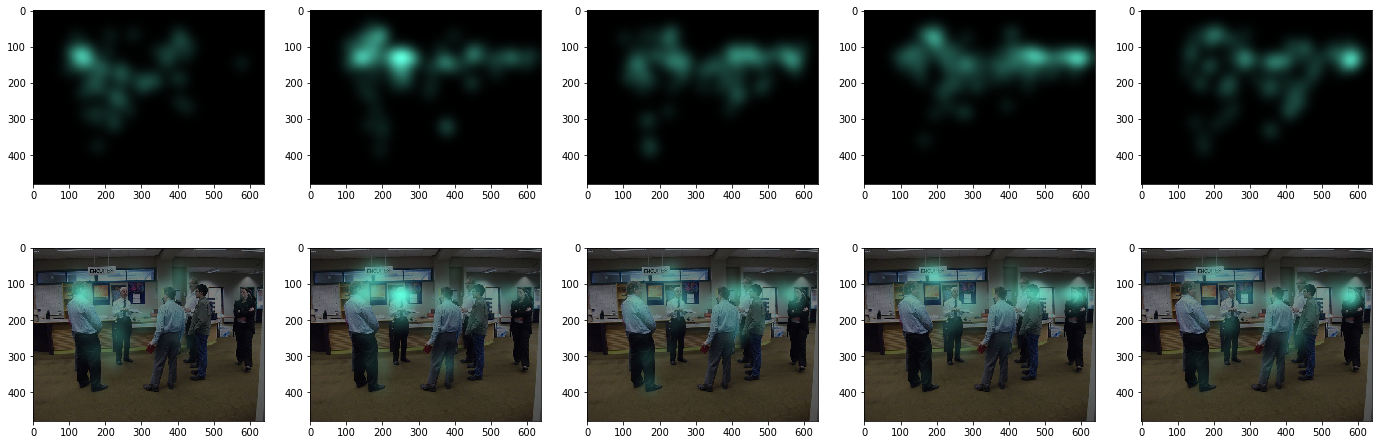

In [20]:
display_images(maps, image)

In [21]:
display_interactive(maps, image)

interactive(children=(IntSlider(value=0, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

### Relationship between saliency volumes and ground truths

In [79]:
REL_SAMPLES = 100

indices = random.sample(range(TRAINING_SIZE), REL_SAMPLES)
saliency_volumes, _ = get_saliency_volumes(np.array(get_filenames(FIXATION_PATH))[indices])

ground_truths = []
for filename in tqdm(np.array(get_filenames(MAP_PATH))[indices]):
    ground_truths.append(imread(MAP_PATH + filename))

In [80]:
x = np.array([], dtype='float')
y = np.array([], dtype='float')

for i in tqdm(range(REL_SAMPLES)):
    ground_truth = ground_truths[i]
    fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volumes[i]
                        for fixation in fix_timestamps], key=lambda x: (x[0])))
    
    x = np.concatenate((x, fix_timestamps[:,0].astype(dtype='float')))
    y = np.concatenate((y, np.array([ground_truth[y - 1, x - 1] for [timestamp, [x, y]] in fix_timestamps], dtype='float')))

In [84]:
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

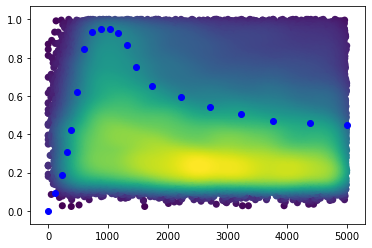

In [85]:
wx = np.array([0, 250, 400, 640, 950, 1250, 1570, 2600, 3700, 5000], dtype='float')
wy = np.array([0, 0.2, 0.45, 0.92, 0.96, 0.92, 0.67, 0.55, 0.47, 0.45], dtype='float')

wx = interp.interp1d(np.arange(len(fx)), fx)(np.linspace(0,len(fx)-1,20))
wy = interp.interp1d(np.arange(len(fy)), fy)(np.linspace(0,len(fy)-1,20))

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
ax.scatter(wx, wy, c='b')
plt.show()

In [259]:
def get_timestamp_weight(ts, wx, wy):
    idx = next(i for i, x in enumerate(wx) if x > ts)
    prev_x = wx[idx-1]
    next_x = wx[idx]
    range_x = (next_x - prev_x)
    
    prev_fac = (next_x - ts) / range_x
    next_fac = (ts - prev_x) / range_x
    return prev_fac * wy[idx-1] + next_fac * wy[idx]

In [40]:
index = random.choice(indices)
filename = get_filenames(FIXATION_PATH)[index]
saliency_volume = get_saliency_volumes([filename], progress_bar=False)[0][0]
image = imread(IMAGE_PATH + filename[:-3] + 'jpg')

fix_timestamps = np.array(sorted([fixation for fix_timestamps in saliency_volume
                                  for fixation in fix_timestamps], key=lambda x: (x[0])))
fix_weights = [[get_timestamp_weight(ts, wx, wy), coord] for [ts, coord] in fix_timestamps]

maps = [imread(MAP_PATH + filename[:-3] + 'png'), create_image(fix_timestamps[:,1]), create_weighted_image(fix_weights)]

NameError: name 'indices' is not defined

In [41]:
display_interactive(maps, image, True)

interactive(children=(IntSlider(value=0, description='i', max=4), Output()), _dom_classes=('widget-interact',)…